<a href="https://colab.research.google.com/github/ShriramGithub7/5_ModelForCIFAR10/blob/main/Advanced_Training_with_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Colab\ Notebooks/*.py


'/content/drive/MyDrive/Colab Notebooks/model.py'


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")

In [4]:
import model
net = model.Net()


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01)
        )

        # Convolution Block
        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.01)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.01)
        )

        # Convolution Block

        self.convblock4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.01)
        )

        # Convolution Block with dilation
        self.convblock5 = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=2, dilation=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.01)
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(64, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.01)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.01)
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 32 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)

# Find mean and std of CIFAR10 dataset

In [17]:
# Loading the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
shuffle=False, num_workers=2)

# Calculating mean and std of RGB channels
mean = 0.
std = 0.
nb_samples = 0.
for data in trainloader:
    img, _ = data
    batch_samples = img.size(0)
    img = img.view(batch_samples, img.size(1), -1)
    mean += img.mean(2).sum(0)
    std += img.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("mean: ", mean)
print("std: ", std)


Files already downloaded and verified
mean:  tensor([0.4914, 0.4822, 0.4465])
std:  tensor([0.2023, 0.1994, 0.2010])


# Apply Albumentation and transformation on dataset

In [18]:
mean=(0.4914, 0.4822, 0.4465)
std=(0.2023, 0.1994, 0.2010)

def albumentations_transform(image):
    image = np.array(image)
    augmented = A.Compose(
                [A.HorizontalFlip(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,rotate_limit=45),
                A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1,min_height=16, min_width=16,
                           fill_value=np.mean(mean), mask_fill_value=None),
        ])(image=image)["image"]
    return transforms.ToTensor()(augmented)

transform = transforms.Compose([
    transforms.Lambda(albumentations_transform),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# View few images from the batch

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def show(img):
  img = img/2 + 0.5
  npimg= img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels= next(dataiter)


show(torchvision.utils.make_grid(images, normalize=False))

print(' '.join('%5s' % classes[labels[j]] for j in range (4)))

images.shape

KeyError: ignored

# Use CUDA as a devide

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create object of the model present in model.py file

In [5]:
!pip install torchsummary
from torchsummary import summary

net = Net().to(device)
summary(net, input_size=(3, 32, 32))

# Setup loss and optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model

In [9]:
for epoch in range(51):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.039
[1,  4000] loss: 1.795
[1,  6000] loss: 1.653
[1,  8000] loss: 1.553
[1, 10000] loss: 1.477
[1, 12000] loss: 1.425
[2,  2000] loss: 1.324
[2,  4000] loss: 1.284
[2,  6000] loss: 1.248
[2,  8000] loss: 1.211
[2, 10000] loss: 1.182
[2, 12000] loss: 1.192
[3,  2000] loss: 1.081
[3,  4000] loss: 1.091
[3,  6000] loss: 1.077
[3,  8000] loss: 1.040
[3, 10000] loss: 1.034
[3, 12000] loss: 1.047
[4,  2000] loss: 0.935
[4,  4000] loss: 0.967
[4,  6000] loss: 0.937
[4,  8000] loss: 0.955
[4, 10000] loss: 0.922
[4, 12000] loss: 0.935
[5,  2000] loss: 0.859
[5,  4000] loss: 0.860
[5,  6000] loss: 0.862
[5,  8000] loss: 0.838
[5, 10000] loss: 0.843
[5, 12000] loss: 0.868
[6,  2000] loss: 0.796
[6,  4000] loss: 0.784
[6,  6000] loss: 0.787
[6,  8000] loss: 0.787
[6, 10000] loss: 0.793
[6, 12000] loss: 0.794
[7,  2000] loss: 0.710
[7,  4000] loss: 0.749
[7,  6000] loss: 0.734
[7,  8000] loss: 0.722
[7, 10000] loss: 0.735
[7, 12000] loss: 0.737
[8,  2000] loss: 0.656
[8,  4000] 

# Test the model for 4 images in a batch

x1:  (3, 36, 138)
GroundTruth:    cat  ship  ship plane


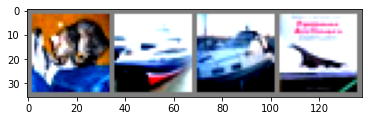

In [11]:
dataiter = iter(testloader)

images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
images, labels = images.to(device), labels.to(device)
outputs = net(images).to(device)
#outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


# Find the accuracy of the model

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
      images, labels= data
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total))


Accuracy of the network on the 10000 test images: 70 %


# Find the accuracy of the each class in the model

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 64 %
Accuracy of   cat : 49 %
Accuracy of  deer : 65 %
Accuracy of   dog : 59 %
Accuracy of  frog : 76 %
Accuracy of horse : 73 %
Accuracy of  ship : 81 %
Accuracy of truck : 78 %


# Plot the graphs